# Double Pendulum Simulation
This program simulates double pendulum for an initial condition

---

### Import necessary module
- `manim` for graphical output
- `sympy` for analytical equation solving
- `numpy` for transcendental functions and other 
- `scipy` for solving ivp numerically

In [68]:
from manim import *
import sympy as smp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Symbol and Function Definitions

This cell defines the symbolic objects used for the analytic derivation of the double-pendulum equations.

- Symbols (parameters):
    - `m1, m2` — masses of the two bobs
    - `l1, l2` — lengths of the two rods
    - `g` — gravitational acceleration

- Time and generalized coordinates:
    - `t` — independent time symbol
    - `theta1(t), theta2(t)` — sympy Function objects representing the time-dependent angles of the first and second pendulum, respectively

Notes:
- Defining `theta1` and `theta2` as Functions of `t` allows taking time derivatives (e.g., `.diff(t)`) for kinetic/potential energy and Euler–Lagrange derivations.
- These are symbolic objects used in subsequent cells to form expressions for positions, velocities, energies, and equations of motion.
- Later in the notebook numeric arrays named `theta1`/`theta2` replace the symbolic functions (after integration). Be careful not to mix the symbolic and numeric meanings in the same scope.

In [69]:
m1, m2, l1, l2, g = smp.symbols("m_1 m_2 l_1 l_2 g")
theta1, theta2 = smp.symbols(r"\theta_1, \theta_2", cls=smp.Function)
t = smp.symbols("t")
theta1 = theta1(t)
theta2 = theta2(t)

### Define the differentials of both of the theta up to second order

In [70]:
theta1_d = theta1.diff(t)
theta2_d = theta2.diff(t)

theta1_dd = theta1.diff(t, 2)
theta2_dd = theta2.diff(t, 2)

### Define cartesian coordinates
Convert the l and theta of to cartesian coordinates to define the kinetic and potential energy easily.

In [71]:
x_1 = l1 * smp.sin(theta1)
y_1 = -l1 * smp.cos(theta1)
x_2 = x_1 + l2 * smp.sin(theta2)
y_2 = y_1 - l2 * smp.cos(theta2)

### Define the Lagrangian
Define the total kinetic and potential energy of the system then define the lagrangian as the difference of the kinetic and potential energy.

In [72]:
# Kinetic
K_1 = (1 / 2) * m1 * (smp.diff(x_1, t) ** 2 + smp.diff(y_1, t) ** 2)
K_2 = (1 / 2) * m2 * (smp.diff(x_2, t) ** 2 + smp.diff(y_2, t) ** 2)
K = K_1 + K_2

# Potential
V_1 = m1 * g * y_1
V_2 = m2 * g * y_2
V = V_1 + V_2

# Lagrangian
L = K - V

### Define Euler-Lagrange equations
For two coordinates theta1 and theta2, we can write two Euler-Lagrange equations.

In [73]:
EL_1 = smp.diff(L, theta1) - smp.diff(smp.diff(L, theta1_d), t)
EL_2 = smp.diff(L, theta2) - smp.diff(smp.diff(L, theta2_d), t)

### Solve for theta1_dd and theta2_dd

THe Euler-Langrange equations are linear in the second differential of thetas. So we can solve for these so we can easily convert each of them into two first order differential equations.

In [74]:
sol = smp.solve([EL_1, EL_2], (theta1_dd, theta2_dd), relational=False, simplify=False)

### Convert symbolic equations
Convert the symbolic equations into python lambda


In [75]:
dz1dt_f = smp.lambdify(
    (t, g, m1, m2, l1, l2, theta1, theta2, theta1_d, theta2_d),
    sol[theta1_dd],
    modules="numpy",
)
dz2dt_f = smp.lambdify(
    (t, g, m1, m2, l1, l2, theta1, theta2, theta1_d, theta2_d),
    sol[theta2_dd],
    modules="numpy",
)

dtheta1_f = smp.lambdify(theta1_d, theta1_d)
dtheta2_f = smp.lambdify(theta2_d, theta2_d)

### Define a combined ODE 

In [76]:
def dSdt(t, S, g, m1, m2, l1, l2):
    theta1, z1, theta2, z2 = S
    dz1dt = dz1dt_f(t, g, m1, m2, l1, l2, theta1, theta2, z1, z2)
    dz2dt = dz2dt_f(t, g, m1, m2, l1, l2, theta1, theta2, z1, z2)
    return [dtheta1_f(z1), dz1dt, dtheta2_f(z2), dz2dt]

### Solve IVP
Use `scipy` to solve the combined ODE.

In [77]:
t = np.linspace(0, 40, 1001)
g = 9.81
l1 = 1.0
l2 = 1.0
m1 = 1.0
m2 = 1.0

ans = sp.integrate.solve_ivp(
    dSdt,
    t_span=(0, 40),
    y0=[np.pi / 2, 0, np.pi / 4, 0],
    t_eval=t,
    args=(g, m1, m2, l1, l2),
    method="RK45",
    atol=1e-12,
    rtol=1e-12,
)

### Extract theta1 and theta2 from the answer

In [78]:
theta1 = ans.y[0]
theta2 = ans.y[2]

### Function to convert angle and length to cartesian coordinates 

In [79]:
def get_x1_y1_x2_y2(t, theta1, theta2, l1, l2):
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)
    return x1, y1, x2, y2


x1, y1, x2, y2 = get_x1_y1_x2_y2(t, theta1, theta2, l1, l2)

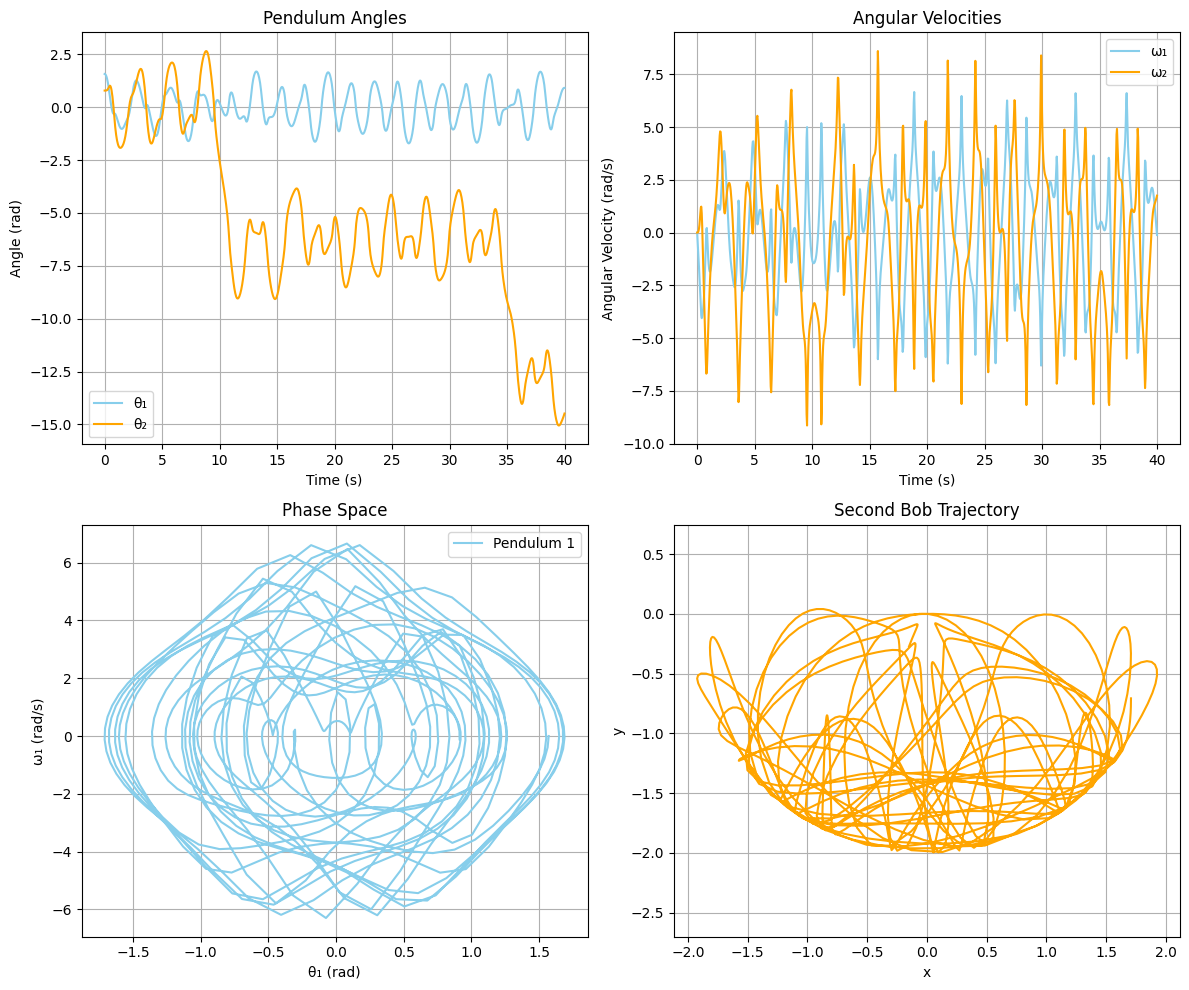

In [80]:
omega1 = ans.y[1]  
omega2 = ans.y[3] 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

ax1.plot(t, theta1, label="θ₁", color='skyblue')
ax1.plot(t, theta2, label="θ₂", color='orange')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angle (rad)")
ax1.set_title("Pendulum Angles")
ax1.legend()
ax1.grid(True)

ax2.plot(t, omega1, label="ω₁", color='skyblue')
ax2.plot(t, omega2, label="ω₂", color='orange')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Angular Velocity (rad/s)")
ax2.set_title("Angular Velocities")
ax2.legend()
ax2.grid(True)

ax3.plot(theta1, omega1, label="Pendulum 1", color='skyblue')
ax3.set_xlabel("θ₁ (rad)")
ax3.set_ylabel("ω₁ (rad/s)")
ax3.set_title("Phase Space")
ax3.legend()
ax3.grid(True)

ax4.plot(x2, y2, label="Bob 2 trajectory", color='orange')
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_title("Second Bob Trajectory")
ax4.grid(True)
ax4.axis('equal')

plt.tight_layout()
plt.show()

### Render with Manim
Render to low quality using `-ql` for quick low quality preview render. For production high quality use `-pqh` instead.

In [81]:
%%manim -ql -v CRITICAL DoublePendulumScene

class DoublePendulumScene(MovingCameraScene):
    def construct(self):
        self.camera.background_color = BLACK
        self.camera.frame.shift(DOWN * 1)
        self.camera.frame.scale(0.5)
        
        rod1 = Line(ORIGIN, [x1[0], y1[0], 0], color=WHITE, stroke_width=2)
        rod2 = Line([x1[0], y1[0], 0], [x2[0], y2[0], 0], color=WHITE, stroke_width=2)
        bob1 = Dot([x1[0], y1[0], 0], radius=0.075, color=RED)
        bob2 = Dot([x2[0], y2[0], 0], radius=0.075, color=BLUE)
        
        path2 = VMobject(color=BLUE, stroke_width=0.5)
        path2.set_points_as_corners([[x2[0], y2[0], 0],[x2[0], y2[0], 0]])

        self.add(path2,rod1, rod2, bob1, bob2)

        def update_pendulum(mob, dt):
            frame_idx = int(self.renderer.time * len(t[t<1]))
            if frame_idx >= len(t):
                frame_idx = len(t) - 1
            
            rod1.put_start_and_end_on(ORIGIN, [x1[frame_idx], y1[frame_idx], 0])
            rod2.put_start_and_end_on([x1[frame_idx], y1[frame_idx], 0], [x2[frame_idx], y2[frame_idx], 0])
            bob1.move_to([x1[frame_idx], y1[frame_idx], 0])
            bob2.move_to([x2[frame_idx], y2[frame_idx], 0])

            path2.add_points_as_corners([[x2[frame_idx], y2[frame_idx], 0]])
    
        
        for m in [rod1, rod2, bob1, bob2, path2]:
            m.add_updater(update_pendulum)
        
        self.wait(t[-1])

Manim Community v0.19.1